<a href="https://colab.research.google.com/github/lgvaz/faststyle/blob/master/examples/hats_on_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !nvidia-smi

In [2]:
# !pip install -q fastai2
# !gdown https://drive.google.com/uc?id=1WcxHwzvhFuzwWPEwiNr4prozGIWQtOVu
# !unzip -q cats.zip

In [3]:
from fastai2.basics import *
from fastai2.vision.all import *
from faststyle import *

In [4]:
source = Path('/home/lgvaz/.data/cats')

In [5]:
def get_y_fn(fn): return fn.with_suffix(fn.suffix+'.cat')
def get_kpts(fn): return np.genfromtxt(fn)[1:].reshape(-1,2)
def get_y(fn):    return get_kpts(get_y_fn(fn))

In [6]:
class CatPoint(TensorPoint):
  @property
  def eyes(self): return (self[0], self[1])
  @property
  def ears(self): return (self[3:6], self[6:9])
  @property
  def leye(self): return min(self.eyes, key=itemgetter(0))
  @property
  def reye(self): return max(self.eyes, key=itemgetter(0))
  @property
  def mouth(self): return self[2]
  @property
  def lear(self): return min(self.ears, key=lambda x: x[0][0])
  @property
  def rear(self): return max(self.ears, key=lambda x: x[0][0])
  @property
  def flip(self): return bool(self.eyes[0][0] > self.eyes[1][0])
  
  # this fails if you dont override
  @classmethod
  def create(cls, t, img_size=None)->None:
    "Convert an array or a list of points `t` to a `Tensor`"
    return cls(tensor(t).view(-1, 2).float(), img_size=img_size)

In [7]:
def get_head_pnts(pt):
  left,top = pt.lear.min(axis=0)[0].numpy()
  right,_  = pt.rear.max(axis=0)[0].numpy()
  bottom = min(pt.leye[1], pt.reye[1])
  pnts = np.array([left,top,right,bottom], dtype=int)
  return pnts

In [8]:
def get_angle(pt):
  x,y = pt.rear[-1] - pt.lear[0] 
  slope = np.divide(y,x, where=x!=0)
  return -np.arctan(slope) * (180/np.pi) + (180 if pt.flip else 0)

In [9]:
def get_size(pnts):
  return pnts[2:]-pnts[:2]

In [10]:
def unscale_pnts(y, sz): return CatPoint((y+1) * tensor(sz).float()/2, img_size=sz)

In [11]:
hat = PILImage.create('hats/hat1.png', mode='RGBA')
def get_hat_pt(pt):
  head = get_head_pnts(pt)
  w,_ = get_size(head)
  # Substitute top of head to maintain hat ratio
  h = w/np.divide(*hat.size)
  if pt.flip: head[-1] = head[1] + h
  else:       head[1] = head[-1] - h
  return head

In [12]:
def put_hat(im, cat_pt, hat_pt, hat):
  im = im.copy()
  hat = hat.resize(get_size(hat_pt)).rotate(get_angle(cat_pt))
  im.paste(hat, hat_pt, hat)
  return im

In [13]:
def get_y2(fn):
  cat_pt = CatPoint.create(get_y(fn))
  hat_pt = get_hat_pt(cat_pt)
  im = PILImage.create(fn)
  im = put_hat(im, cat_pt, hat_pt, hat)
  return PILImage(im)

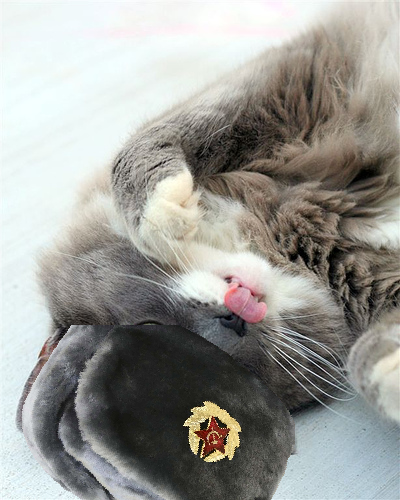

In [14]:
# fn = fns[1]
fn = source/'CAT_02/00000510_005.jpg'
get_y2(fn)

In [15]:
dblock = DataBlock((ImageBlock, ImageBlock), get_y=get_y2, get_items=get_image_files, splitter=RandomSplitter(.1),
                   item_tfms=[Resize(128)], batch_tfms=[Normalize.from_stats(*imagenet_stats)])

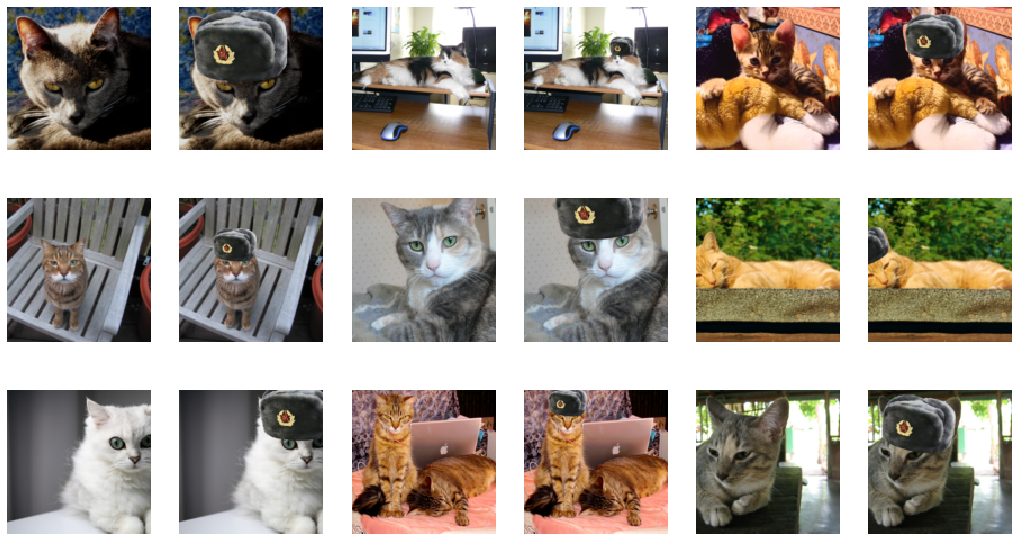

In [16]:
dls = dblock.dataloaders(source, bs=30); dls.c = 3
dls.show_batch()

In [17]:
get_feats = LayerFeats.from_feat_m(FeatModels.vgg16)

In [18]:
loss_func = FastStyleLoss(get_feats, stl_w=0, tv_w=0, cnt_w=1)

In [19]:
stl_fns = ['styles/abstract.jpg'] # Ignored
cbs = SourceFeatsCallback.from_fns(stl_fns, get_feats)
cfg = unet_config(blur=True, self_attention=True, norm_type=NormType.Weight, y_range=(-1,1))
learn = unet_learner(dls=dls, arch=resnet34, loss_func=loss_func, cbs=cbs, config=cfg)
# learn = style_learner(dls, TransformerNet(), get_feats, stl_fns, loss_func=loss_func,)

In [20]:
# learn.lr_find()

In [21]:
learn.fit_one_cycle(6, 1e-3, pct_start=.72)

epoch,train_loss,valid_loss,time
0,46.869114,44.510517,03:02
1,33.128033,31.908577,03:01
2,24.747551,24.620632,02:57
3,20.585201,21.215776,02:51
4,18.092392,18.310677,02:50
5,15.552916,16.607321,02:53


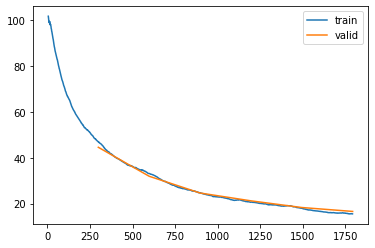

In [22]:
learn.recorder.plot_loss()

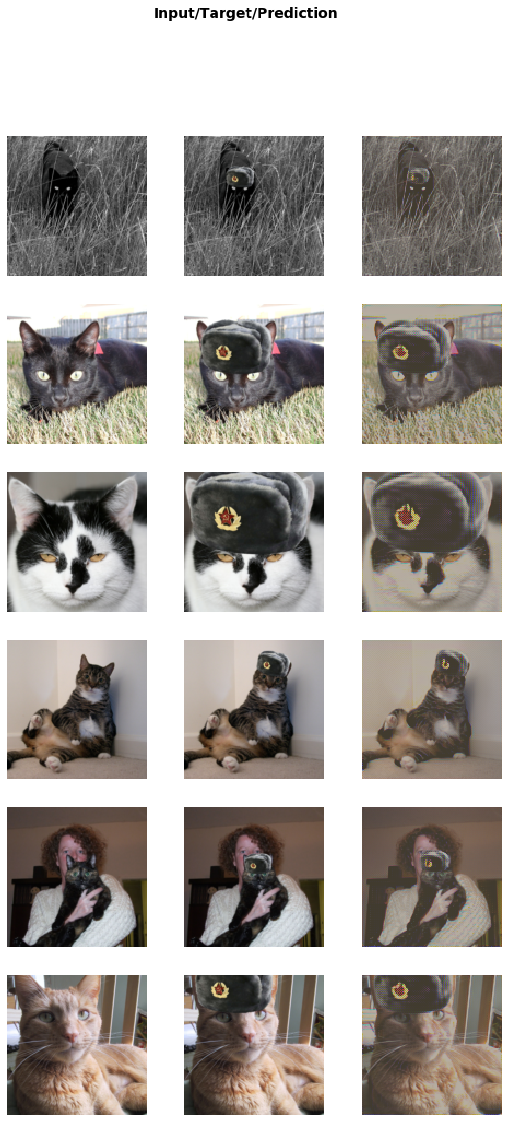

In [23]:
learn.show_results()

In [24]:
learn.unfreeze()

In [25]:
learn.fit_one_cycle(6, slice(1e-6,1e-4), pct_start=0.72)

epoch,train_loss,valid_loss,time
0,14.959912,16.512583,03:00
1,15.069380,16.423637,03:01
2,14.884740,16.411333,03:01
3,14.833457,16.139360,03:02
4,14.207145,15.872949,03:00
5,13.959467,15.709019,03:03


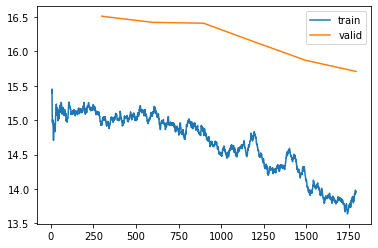

In [26]:
learn.recorder.plot_loss()

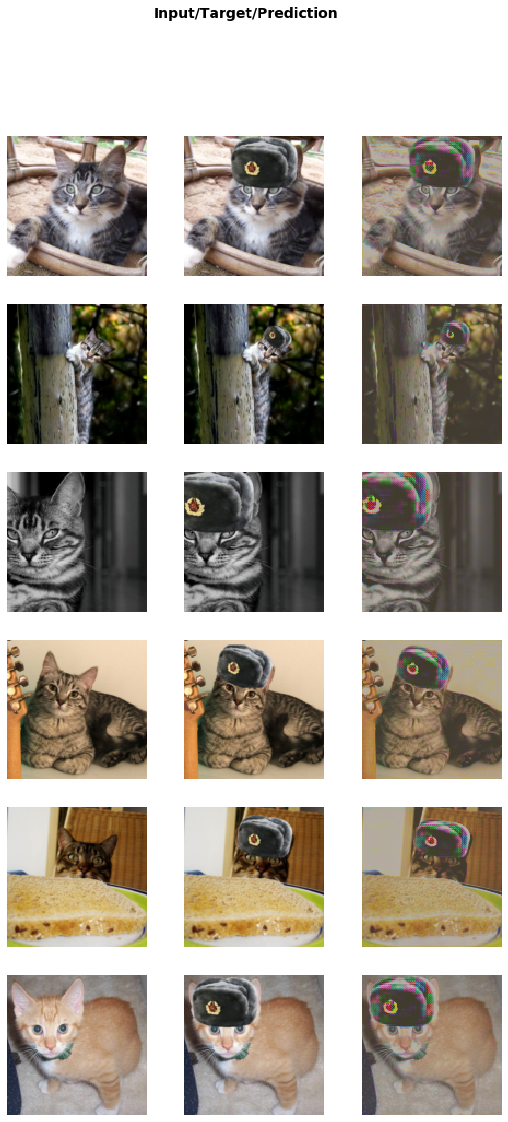

In [27]:
learn.show_results()